In [1]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import pyfiles.PMNISTDataLoader as DataLoader
import pyfiles.models as models
import pyfiles.train as train
import pyfiles.eval as evalu
import pyfiles.lib as lib

In [3]:
num_task = 10
batch_size = 128
train_loader, test_loader = lib.setPMNISTDataLoader(num_task, batch_size)

In [4]:
hidden_layer_num = 1000
epochs = 100

### Plain

In [5]:
net = models.FCNetwork(hidden_layer_num)
crit = torch.nn.CrossEntropyLoss()
if torch.cuda.is_available():
    net = net.cuda(3)
    crit = crit.cuda(3)

optim = torch.optim.SGD(net.parameters(), lr=0.001)
plain_acc = {}
for t in range(num_task):
    train.FineTuning(
        dataloader = train_loader[t],
        epochs = epochs, 
        optim = optim,
        crit = crit,
        net = net,
    )
    
    each_task_acc, acc_mean = evalu.eval(
        dataloader = test_loader,
        num_task = t,
        net = net
    )
    print(each_task_acc)
    plain_acc[t] = acc_mean


[Epoch 20/100] Loss: 503.108
[Epoch 40/100] Loss: 315.067
[Epoch 60/100] Loss: 253.982
[Epoch 80/100] Loss: 207.756
[Epoch 100/100] Loss: 172.592
[Task 1] avg accuracy: 94.670%
tensor([94.6700], device='cuda:3')


/home/mind-222/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


[Epoch 20/100] Loss: 206.324
[Epoch 40/100] Loss: 152.285
[Epoch 60/100] Loss: 120.917
[Epoch 80/100] Loss: 99.434
[Epoch 100/100] Loss: 83.517
[Task 2] avg accuracy: 93.730%
tensor([90.6500, 96.8100], device='cuda:3')


KeyboardInterrupt: 

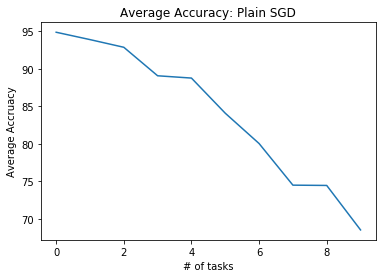

In [4]:
x, y = list(plain_acc.keys()), list(plain_acc.values())
plt.xlabel('# of tasks')
plt.ylabel('Average Accruacy')
plt.title('Average Accuracy: Plain SGD')
plt.plot(x, y)
plt.show()

### L2

In [8]:
hidden_layer_num = 400
epochs = 100
ld_list = [10000, 30000]
#past_task_params = torch.empty(0)
l2_acc = {}

for ld in ld_list:
    print("Lambda %f"%(ld))
    net = models.FCNetwork(hidden_layer_num)
    crit = torch.nn.CrossEntropyLoss()
    if torch.cuda.is_available():
        #past_task_params = past_task_params.cuda()
        net = net.cuda()
        crit = crit.cuda()

    past_task_params = []
    optim = torch.optim.SGD(net.parameters(), lr=0.001)    
    l2_acc_per_ld = {}
    for t in range(num_task):
        train.L2Learning(
            past_task_params = past_task_params,
            dataloader = train_loader[t],
            epochs = epochs,
            optim = optim,
            crit = crit,
            net = net,
            ld = ld
        )

        each_task_acc, acc_mean = evalu.eval(
            dataloader = test_loader,
            num_task = t,
            net = net
        )
        print(each_task_acc)
        l2_acc_per_ld[t] = acc_mean
        
    l2_acc[ld] = l2_acc_per_ld

Lambda 10000.000000
[Epoch 20/100] Loss: 450.571
[Epoch 40/100] Loss: 303.737
[Epoch 60/100] Loss: 244.009
[Epoch 80/100] Loss: 196.953
[Epoch 100/100] Loss: 161.218
[Task 1] avg accuracy: 94.950%
tensor([94.9500], device='cuda:0')
[Epoch 20/100] Loss: 197.031
[Epoch 40/100] Loss: 141.334
[Epoch 60/100] Loss: 110.965
[Epoch 80/100] Loss: 90.726
[Epoch 100/100] Loss: 75.859
[Task 2] avg accuracy: 93.660%
tensor([90.4100, 96.9100], device='cuda:0')
[Epoch 20/100] Loss: 134.805
[Epoch 40/100] Loss: 93.943
[Epoch 60/100] Loss: 72.416
[Epoch 80/100] Loss: 58.074
[Epoch 100/100] Loss: 47.521
[Task 3] avg accuracy: 92.310%
tensor([87.9200, 91.6600, 97.3500], device='cuda:0')
[Epoch 20/100] Loss: 107.431
[Epoch 40/100] Loss: 71.598
[Epoch 60/100] Loss: 53.128
[Epoch 80/100] Loss: 41.133
[Epoch 100/100] Loss: 32.592
[Task 4] avg accuracy: 88.337%
tensor([82.3900, 82.9200, 90.6700, 97.3700], device='cuda:0')
[Epoch 20/100] Loss: 86.493
[Epoch 40/100] Loss: 55.000
[Epoch 60/100] Loss: 39.415
[Epo

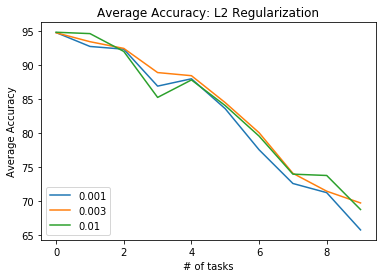

In [7]:
plt.xlabel('# of tasks')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy: L2 Regularization')

for coef, acc_dict in l2_acc.items():
    x, y = list(acc_dict.keys()), list(acc_dict.values())
    plt.plot(x, y, label=str(coef))
    
plt.legend(loc=3)
if not os.path.isdir("plots"):
    os.mkdir("plots")
    
plt.savefig("plots/L2_result.png", dpi=300)
plt.show()

### EWC

In [9]:
ld_list=[100]
ewc_acc = {}

for ld in ld_list:
    print("Lambda %f"%(ld))
    net = models.FCNetwork(hidden_layer_num)
#     net = models.ConvolutionNetwork()

    crit = torch.nn.CrossEntropyLoss()
    if torch.cuda.is_available():
        net = net.cuda(3)
        crit = crit.cuda(3)

    past_task_params = []
    past_fisher_mat = []
    optim = torch.optim.SGD(net.parameters(), lr=0.001)
    ewc_acc_per_ld = {}
    for t in range(num_task):
        train.EWCLearning(
            past_task_params = past_task_params,
            past_fisher_mat = past_fisher_mat,
            dataloader = train_loader[t],
            epochs = epochs,
            optim = optim,
            crit = crit,
            net = net,
            ld = ld
        )

        each_task_acc, acc_mean = evalu.eval(
            dataloader = test_loader,
            num_task = t,
            net = net
        )
        print(each_task_acc)
        ewc_acc_per_ld[t] = acc_mean
        
    ewc_acc[ld] = ewc_acc_per_ld

Lambda 100.000000


/home/mind-222/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


[Epoch 20/100] Loss: 367.124
[Epoch 40/100] Loss: 231.764
[Epoch 60/100] Loss: 190.859
[Epoch 80/100] Loss: 167.632
[Epoch 100/100] Loss: 150.761


/home/mind-222/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


[Task 1] avg accuracy: 92.520%
tensor([92.5200], device='cuda:3')
[Epoch 20/100] Loss: 205.274
[Epoch 40/100] Loss: 164.546
[Epoch 60/100] Loss: 141.502
[Epoch 80/100] Loss: 127.952
[Epoch 100/100] Loss: 116.363
[Task 2] avg accuracy: 92.615%
tensor([90.8400, 94.3900], device='cuda:3')
[Epoch 20/100] Loss: 183.477
[Epoch 40/100] Loss: 147.864
[Epoch 60/100] Loss: 129.957
[Epoch 80/100] Loss: 116.924
[Epoch 100/100] Loss: 108.061
[Task 3] avg accuracy: 92.657%
tensor([89.9400, 92.8100, 95.2200], device='cuda:3')
[Epoch 20/100] Loss: 183.329
[Epoch 40/100] Loss: 149.852
[Epoch 60/100] Loss: 131.986
[Epoch 80/100] Loss: 119.921
[Epoch 100/100] Loss: 111.840
[Task 4] avg accuracy: 92.872%
tensor([89.8300, 92.3300, 93.9500, 95.3800], device='cuda:3')
[Epoch 20/100] Loss: 188.089
[Epoch 40/100] Loss: 154.078
[Epoch 60/100] Loss: 136.859
[Epoch 80/100] Loss: 126.882
[Epoch 100/100] Loss: 119.250
[Task 5] avg accuracy: 92.658%
tensor([88.4200, 92.0800, 92.7600, 94.6400, 95.3900], device='cuda:

In [8]:
print(ewc_acc)
print(each_task_acc)

{100: {0: tensor(92.4900, device='cuda:3'), 1: tensor(92.6300, device='cuda:3'), 2: tensor(92.7533, device='cuda:3'), 3: tensor(92.8250, device='cuda:3'), 4: tensor(92.5880, device='cuda:3'), 5: tensor(92.1250, device='cuda:3'), 6: tensor(91.8271, device='cuda:3'), 7: tensor(90.6362, device='cuda:3'), 8: tensor(89.9400, device='cuda:3'), 9: tensor(89.9090, device='cuda:3')}, 300: {0: tensor(92.1700, device='cuda:3'), 1: tensor(92.4950, device='cuda:3'), 2: tensor(92.5433, device='cuda:3'), 3: tensor(92.7675, device='cuda:3'), 4: tensor(92.4000, device='cuda:3'), 5: tensor(91.6733, device='cuda:3'), 6: tensor(91.0114, device='cuda:3'), 7: tensor(89.2300, device='cuda:3'), 8: tensor(87.0400, device='cuda:3'), 9: tensor(85.9270, device='cuda:3')}, 1000: {0: tensor(92.3700, device='cuda:3'), 1: tensor(92.6450, device='cuda:3'), 2: tensor(92.5600, device='cuda:3'), 3: tensor(92.7475, device='cuda:3'), 4: tensor(91.9260, device='cuda:3'), 5: tensor(90.8067, device='cuda:3'), 6: tensor(89.227

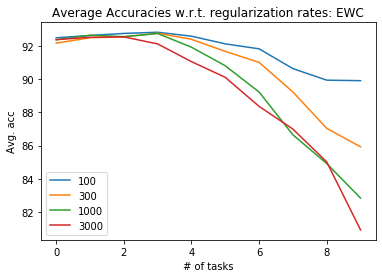

In [7]:
plt.xlabel("# of tasks")
plt.ylabel("Avg. acc")
plt.title("Average Accuracies w.r.t. regularization rates: EWC")

for coef, acc_dict in ewc_acc.items():
    x, y = list(acc_dict.keys()), list(acc_dict.values())
    plt.plot(x, y, label=str(coef))

plt.legend(loc=3)
plt.show()

{100: {0: tensor(92.5200, device='cuda:3'), 1: tensor(92.6150, device='cuda:3'), 2: tensor(92.6567, device='cuda:3'), 3: tensor(92.8725, device='cuda:3'), 4: tensor(92.6580, device='cuda:3'), 5: tensor(92.2333, device='cuda:3'), 6: tensor(91.6029, device='cuda:3'), 7: tensor(90.8025, device='cuda:3'), 8: tensor(89.7800, device='cuda:3'), 9: tensor(89.2740, device='cuda:3')}}


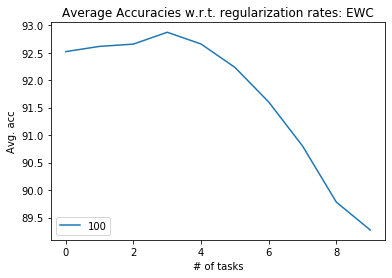

In [11]:
print(ewc_acc)
plt.xlabel("# of tasks")
plt.ylabel("Avg. acc")
plt.title("Average Accuracies w.r.t. regularization rates: EWC")

for coef, acc_dict in ewc_acc.items():
    x, y = list(acc_dict.keys()), list(acc_dict.values())
    plt.plot(x, y, label=str(coef))

plt.legend(loc=3)
plt.show()